In [23]:
#Подключение библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima  
from sklearn.metrics import mean_squared_error 
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model

import warnings 
warnings.filterwarnings("ignore") 


Анализ данных и предварительная обработка

In [24]:
#Загрузка первого датасета с информацией стоимости продуктов
df1 = pd.read_csv('wfp_food_prices_rus_extended.csv')
df1.head(12000)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,currency,price
0,2008-04-15,Altay Rep.,Administrative unit not available,Western Siberia,50.92,86.92,cereals and tubers,Wheat flour (high grade),KG,actual,RUB,13.50
1,2008-04-15,Chuvashiya Rep.,Administrative unit not available,Volga-Vyatka region,55.55,47.10,milk and dairy,Milk,L,actual,RUB,29.07
2,2008-04-15,Tatarstan Rep.,Administrative unit not available,Volga region,55.79,49.13,vegetables and fruits,Oranges,KG,actual,RUB,42.39
3,2008-04-15,Sverdlovskaya Oblast,Administrative unit not available,Ural region,58.70,61.33,vegetables and fruits,Apples,KG,actual,RUB,72.40
4,2008-04-15,Rostovskaya Oblast,Administrative unit not available,Southern region,47.23,39.70,cereals and tubers,Rice,KG,actual,RUB,25.37
...,...,...,...,...,...,...,...,...,...,...,...,...
11001,2020-03-15,Sverdlovskaya Oblast,Administrative unit not available,Ural region,58.70,61.33,cereals and tubers,Rice,KG,actual,RUB,33.20
11002,2020-03-15,Lipetskaya Oblast,Administrative unit not available,Central Black Earth,52.70,39.15,cereals and tubers,Rice,KG,actual,RUB,33.83
11003,2020-03-15,Tatarstan Rep.,Administrative unit not available,Volga region,55.79,49.13,cereals and tubers,Wheat flour (high grade),KG,actual,RUB,19.00
11004,2020-03-15,Altay Rep.,Administrative unit not available,Western Siberia,50.92,86.92,milk and dairy,Cheese,KG,actual,RUB,266.90


In [25]:
#Анализ датасета
def analyze_dataset(df):

    # тип датасета
    print(type(df))
    print("*"*50)

    # размер датасета
    print("Shape of the dataset:", df.shape,'\n')
    print("*"*50)

    # пропущенные значения
    null_counts = df.isnull().sum()
    print("Null columns only:", null_counts[null_counts > 0])
    print("*"*50)

    # дубликаты
    print("Number of duplicates:", len(df.loc[df.duplicated()]),'\n')
    print("*"*50)

    # количество столбцов
    num_columns = len(df.columns)
    print("Number of columns:", num_columns)
    print("*"*50)

    # уникальные значения
    print("The unique values per column are:")
    print(df.nunique(), '\n')
    print("*"*50)

    print("The unique Russian Regions are:")
    print(df['admin1'].unique(),'\n')
    print("*"*50)

    print("The unique Russian Markets are:")
    print(df['market'].unique(),'\n')
    print("*"*50)

    print("The unique Food Categories are:")
    print(df['category'].unique(),'\n')
    print("*"*50)

    print("The unique Russian Commodities are:")
    print(df['commodity'].unique(),'\n')
    print("*"*50)


    # Общая информация по датасету
    print("Information about the dataset:")
    print(df.info())
    print("*"*50)

analyze_dataset(df1)

<class 'pandas.core.frame.DataFrame'>
**************************************************
Shape of the dataset: (11006, 12) 

**************************************************
Null columns only: Series([], dtype: int64)
**************************************************
Number of duplicates: 21 

**************************************************
Number of columns: 12
**************************************************
The unique values per column are:
date          144
admin1          8
admin2          1
market          8
latitude        8
longitude       8
category        3
commodity       6
unit            2
priceflag       1
currency        1
price        6364
dtype: int64 

**************************************************
The unique Russian Regions are:
['Altay Rep.' 'Chuvashiya Rep.' 'Tatarstan Rep.' 'Sverdlovskaya Oblast'
 'Rostovskaya Oblast' 'Sankt-peterburg' 'Moskva' 'Lipetskaya Oblast'] 

**************************************************
The unique Russian Markets are:
['W

In [26]:
#Просмотр дубликатов
duplicates = df1[df1.duplicated(keep=False)]
print(duplicates)
df1 = df1.drop_duplicates(keep='last')

             date                admin1                             admin2  \
385    2008-09-15       Sankt-peterburg  Administrative unit not available   
436    2008-09-15       Sankt-peterburg  Administrative unit not available   
1010   2009-05-15       Sankt-peterburg  Administrative unit not available   
1024   2009-05-15       Sankt-peterburg  Administrative unit not available   
1176   2009-07-15       Chuvashiya Rep.  Administrative unit not available   
1179   2009-07-15       Chuvashiya Rep.  Administrative unit not available   
1749   2010-02-15                Moskva  Administrative unit not available   
1824   2010-02-15                Moskva  Administrative unit not available   
2122   2010-06-15    Rostovskaya Oblast  Administrative unit not available   
2155   2010-06-15    Rostovskaya Oblast  Administrative unit not available   
2170   2010-06-15        Tatarstan Rep.  Administrative unit not available   
2180   2010-06-15        Tatarstan Rep.  Administrative unit not

In [27]:
#Загрузка второго датасета с информацией по инфляции
df2 = pd.read_excel('Inflation.xlsx')
df2.head(100)

,date,key rate,inflation
0,2.2020,6.00,2.30
1,1.2020,6.25,2.40
2,12.2019,6.25,3.00
3,11.2019,6.50,3.50
4,10.2019,6.50,3.80
...,...,...,...
73,1.2014,5.50,6.07
74,12.2013,5.50,6.47
75,11.2013,5.50,6.50
76,10.2013,5.50,6.27


In [28]:
#Загрузка третьего датасета с информацией погодных условий
df3 = pd.read_excel('rus-rainfall-adm2-full.xlsx')
df3.head()

,date,r1h
0,2008-04-11,48.6389
1,2008-04-21,44.9087
2,2008-05-01,56.1429
3,2008-05-11,64.4444
4,2008-05-21,58.8611


In [29]:
# Приводим df1["date"] к формату "YYYY-MM-15"
df1["date"] = pd.to_datetime(df1["date"]).dt.strftime("%Y-%m")  # Преобразуем к формату "YYYY-MM"
df1["date"] = df1["date"] + "-15"  # Устанавливаем день на 15

# Преобразуем df2["date"] в формат "YYYY-MM-15"
# Если месяц однозначный, добавляем 0 перед ним
df2['date'] = df2['date'].apply(lambda x: str(x).zfill(5) if len(str(x).split('.')[0]) == 1 else str(x))  # Добавляем 0 перед месяцем
df2['date'] = pd.to_datetime(df2['date'], format='%m.%Y', errors='coerce')  # Преобразуем в datetime формат
df2['date'] = df2['date'].dt.strftime('%Y-%m')  # Преобразуем в формат YYYY-MM
df2['date'] = df2['date'] + "-15"  # Устанавливаем день на 15
df2.at[0, "date"] = "2020-01-15"
df2.at[1, "date"] = "2020-02-15"
df3["date"] = pd.to_datetime(df3["date"], errors='coerce')  # Преобразуем в datetime формат
df3 = df3[df3["date"].dt.day == 11]  # Оставляем только строки, где день == 11
df3["date"] = df3["date"].apply(lambda x: x.replace(day=15))  # Меняем день на 15
df3["date"] = df3["date"].dt.strftime("%Y-%m-%d")  # Приводим к формату "YYYY-MM-15"

# Объединяем df1 и df2 по "date"
merged_df = df1.merge(df2, on="date", how="left")

# Объединяем df1 и df3 по "date"
merged_df = merged_df.merge(df3, on="date", how="left")

merged_df.head(10900)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,currency,price,key rate,inflation,r1h
0,2008-04-15,Altay Rep.,Administrative unit not available,Western Siberia,50.92,86.92,cereals and tubers,Wheat flour (high grade),KG,actual,RUB,13.50,NaN,NaN,48.6389
1,2008-04-15,Chuvashiya Rep.,Administrative unit not available,Volga-Vyatka region,55.55,47.10,milk and dairy,Milk,L,actual,RUB,29.07,NaN,NaN,48.6389
2,2008-04-15,Tatarstan Rep.,Administrative unit not available,Volga region,55.79,49.13,vegetables and fruits,Oranges,KG,actual,RUB,42.39,NaN,NaN,48.6389
3,2008-04-15,Sverdlovskaya Oblast,Administrative unit not available,Ural region,58.70,61.33,vegetables and fruits,Apples,KG,actual,RUB,72.40,NaN,NaN,48.6389
4,2008-04-15,Rostovskaya Oblast,Administrative unit not available,Southern region,47.23,39.70,cereals and tubers,Rice,KG,actual,RUB,25.37,NaN,NaN,48.6389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10895,2020-02-15,Altay Rep.,Administrative unit not available,Western Siberia,50.92,86.92,milk and dairy,Milk,L,actual,RUB,44.55,6.25,2.4,49.3810
10896,2020-02-15,Altay Rep.,Administrative unit not available,Western Siberia,50.92,86.92,vegetables and fruits,Oranges,KG,actual,RUB,52.66,6.25,2.4,49.3810
10897,2020-02-15,Sankt-peterburg,Administrative unit not available,North-West region,59.93,30.34,vegetables and fruits,Oranges,KG,actual,RUB,68.02,6.25,2.4,49.3810
10898,2020-02-15,Lipetskaya Oblast,Administrative unit not available,Central Black Earth,52.70,39.15,milk and dairy,Milk,L,actual,RUB,47.75,6.25,2.4,49.3810


In [30]:
merged_df.describe()

,latitude,longitude,price,key rate,inflation,r1h
count,10985.000000,10985.000000,10985.000000,5541.000000,5541.000000,10985.000000
mean,54.504800,49.081687,62.013066,9.022920,7.214566,47.400110
std,4.019727,17.206592,68.138985,2.511852,4.450314,21.536267
min,47.230000,30.340000,6.300000,5.500000,2.200000,10.099200
25%,50.920000,39.150000,22.560000,7.250000,3.900000,32.313500
50%,55.750000,39.700000,33.490000,8.000000,6.140000,43.119000
75%,58.700000,61.330000,62.970000,11.000000,8.100000,57.805600
max,59.930000,86.920000,356.190000,17.000000,16.900000,120.603200


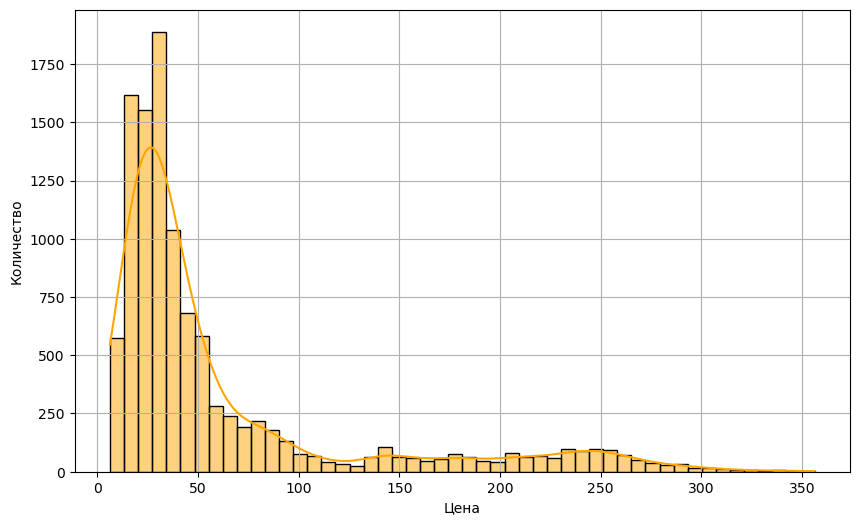

In [31]:
# Гистограмма распределения цен в датасете

plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='price', bins=50, kde=True, color='orange')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

Summary Statistics:
count    78.000000
mean      6.770513
std       4.273646
min       2.200000
25%       3.800000
50%       5.600000
75%       7.580000
max      16.900000
Name: inflation, dtype: float64
**************************************************


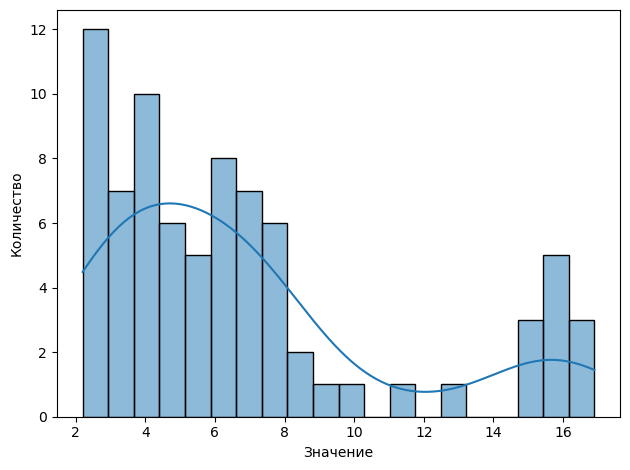

In [32]:
# Суммарная статистика
summary_stats = df2[ 'inflation'].describe()
print("Summary Statistics:")
print(summary_stats)
print("*" * 50)

sns.histplot(df2['inflation'], bins=20, kde=True)
plt.xlabel("Значение")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

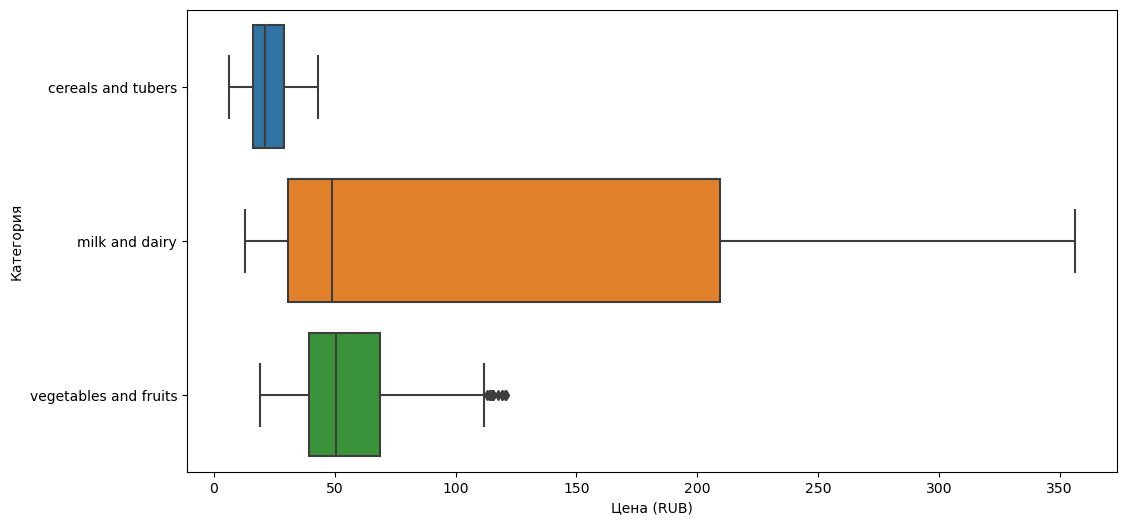

In [33]:
#Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='price', y='category', data=merged_df)
plt.xlabel('Цена (RUB)')
plt.ylabel('Категория')
plt.show()

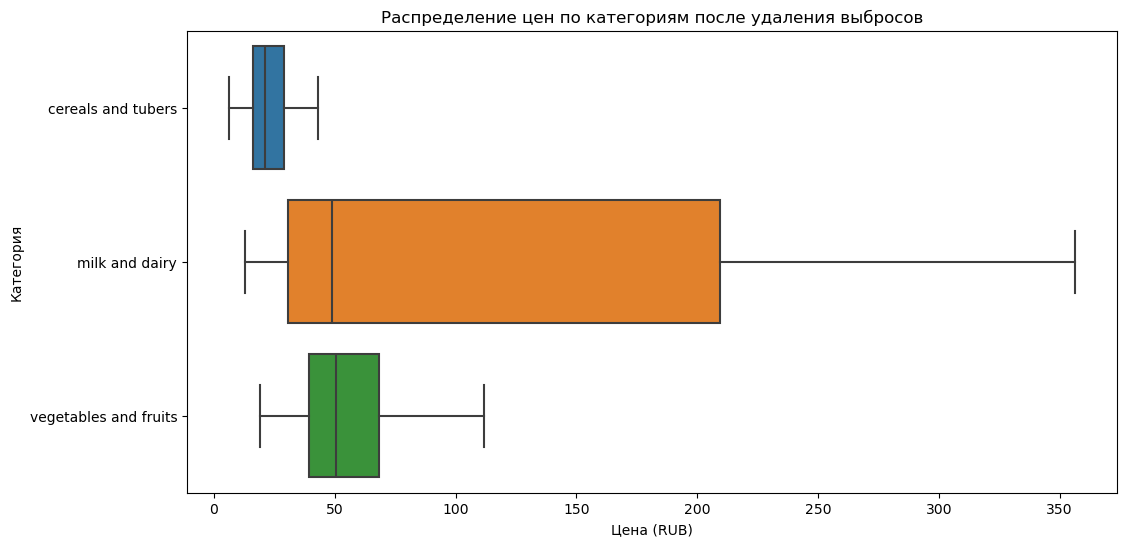

In [34]:
# Функция для удаления выбросов по каждой категории
def remove_outliers(df, column, groupby):
    Q1 = df.groupby(groupby)[column].transform('quantile', 0.25)
    Q3 = df.groupby(groupby)[column].transform('quantile', 0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем только те значения, которые попадают в границы
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

# Удаляем выбросы по цене в каждой категории
cleaned_df = remove_outliers(merged_df, 'price', 'category')

# График после удаления выбросов

plt.figure(figsize=(12, 6))
sns.boxplot(x='price', y='category', data=cleaned_df)
plt.xlabel('Цена (RUB)')
plt.ylabel('Категория')
plt.title('Распределение цен по категориям после удаления выбросов')
plt.show()

Text(0, 0.5, 'Регион')

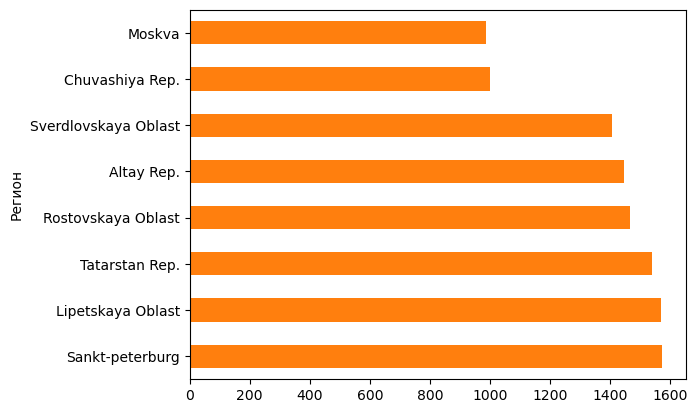

In [35]:
#Распределение количества строк в датасете по регионам
province_counts = merged_df['admin1'].value_counts()
province_counts.plot(kind='barh', color='#ff7f0e')
plt.ylabel("Регион")

In [36]:
#для каждого уникального значения столбца date вычислено среднее значение цены на продукты - для использования в методах
df_time_series = merged_df.groupby("date", as_index=False)["price"].mean()
df_time_series.head()

,date,price
0,2008-04-15,52.590543
1,2008-05-15,58.568197
2,2008-06-15,51.668312
3,2008-07-15,67.259403
4,2008-08-15,61.883333


Метод SARIMA

In [37]:
#Подбор параметров для SARIMA
stepwise_fit = auto_arima(df_time_series['price'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)     

stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1152.544, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1058.397, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1155.814, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1083.146, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1054.018, Time=0.23 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1095.932, Time=0.17 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1038.801, Time=0.26 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1046.305, Time=0.12 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1040.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -513.400
Date:                            Tue, 13 May 2025   AIC                           1038.801
Time:                                    21:42:56   BIC                           1056.098
Sample:                                         0   HQIC                          1045.830
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9862      1.407      1.412      0.158      -0.771       4.743
ar.L1          0.3599      0.076      4.710      0.000       0.210       0.510
ar.L2          0.3543      0.079      4.464      0.000       0.199       0.510
ar.S.L12      -0.6310      0.091     -6.956      0.000      -0.809      -0.453
ar.S.L24      -0.2941      0.092     -3.182      0.001      -0.475      -0.113
sigma2       133.7094     17.816      7.505      0.000      98.791     168.628
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.85   Prob(JB):                         0.87
Heteroskedasticity (H):               2.10   Skew:                             0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
train = df_time_series.iloc[:len(df_time_series)-36] 
test = df_time_series.iloc[len(df_time_series)-36:] # set one year(12 months) for testing 
  
# Тренируем SARIMA(2, 0, 0)x(2, 1, 0, 12) на train датасете
model = SARIMAX(train['price'],  
                order = (2, 0, 0),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  108
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -369.630
Date:                            Tue, 13 May 2025   AIC                            749.260
Time:                                    21:42:58   BIC                            762.082
Sample:                                         0   HQIC                           754.443
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4207      0.099      4.231      0.000       0.226       0.616
ar.L2          0.3641      0.103      3.548      0.000       0.163       0.565
ar.S.L12      -0.6016      0.097     -6.201      0.000      -0.792      -0.411
ar.S.L24      -0.2503      0.101     -2.482      0.013      -0.448      -0.053
sigma2       122.3102     19.123      6.396      0.000      84.830     159.790
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.36   Prob(JB):                         0.83
Heteroskedasticity (H):               3.16   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

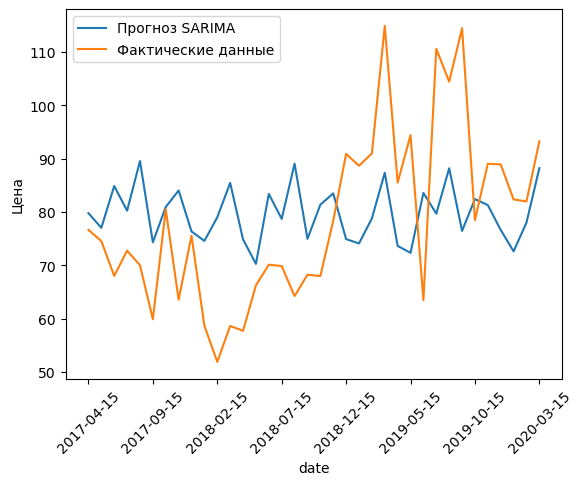

In [40]:
test.set_index('date', inplace=True)

# Прогнозируем, присваивая индекс с датами
start = len(train) 
end = len(train) + len(test) - 1

predictions = result.predict(start, end, typ='levels').rename("Прогноз SARIMA")
predictions.index = test.index  # Присваиваем индекс с датами

# Построение графика
predictions.plot(label="Прогноз SARIMA", legend=True)
test['price'].plot(label="Фактические данные", legend=True)
plt.xticks(rotation=45)
plt.ylabel("Цена")
plt.show()

In [41]:
rmse = np.sqrt(mean_squared_error(test["price"], predictions))
mape = mean_absolute_percentage_error(test["price"], predictions) * 100
print("RMSE:", rmse)
print("MAPE:", mape)

RMSE: 16.610893632743036
MAPE: 18.383299433266693


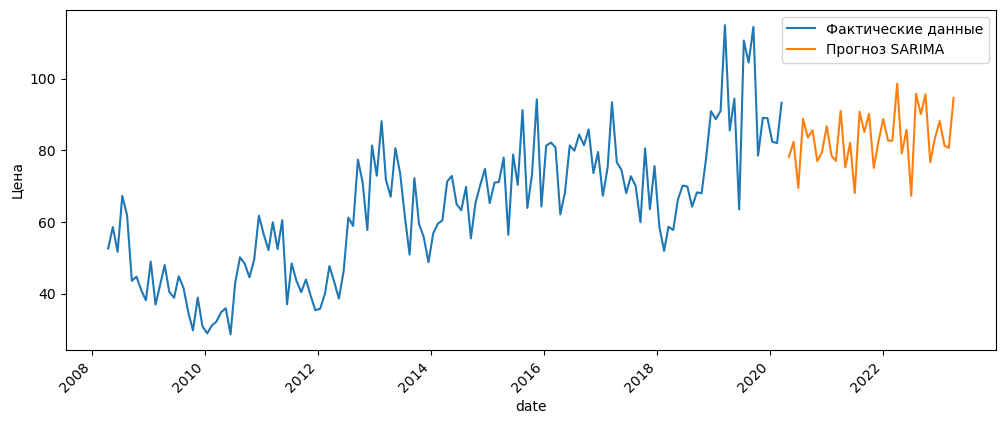

In [42]:
# Подготовка данных
df_time_series['date'] = pd.to_datetime(df_time_series['date'])
df_time_series.set_index('date', inplace=True)

# Обучение модели
model = SARIMAX(df_time_series['price'],  
                order=(2, 0, 0),  
                seasonal_order=(2, 1, 0, 12)) 
result = model.fit()

# Генерация дат для прогноза
forecast_index = pd.date_range(start=df_time_series.index[-1], periods=3 * 12 + 1, freq='MS')[1:]

# Прогнозирование
forecast = result.predict(start=len(df_time_series),  
                          end=(len(df_time_series) - 1) + 3 * 12,  
                          typ='levels').rename('Прогноз SARIMA')

forecast.index = forecast_index  # Присваиваем индекс

# Построение графика с подписями
df_time_series['price'].plot(figsize=(12, 5), label='Фактические данные', legend=True)
forecast.plot(label='Прогноз SARIMA', legend=True)

plt.ylabel('Цена')
plt.xticks(rotation=45)
plt.show()


In [ ]:
Метод 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}
RMSE: 15.81
MAPE: 16.45%


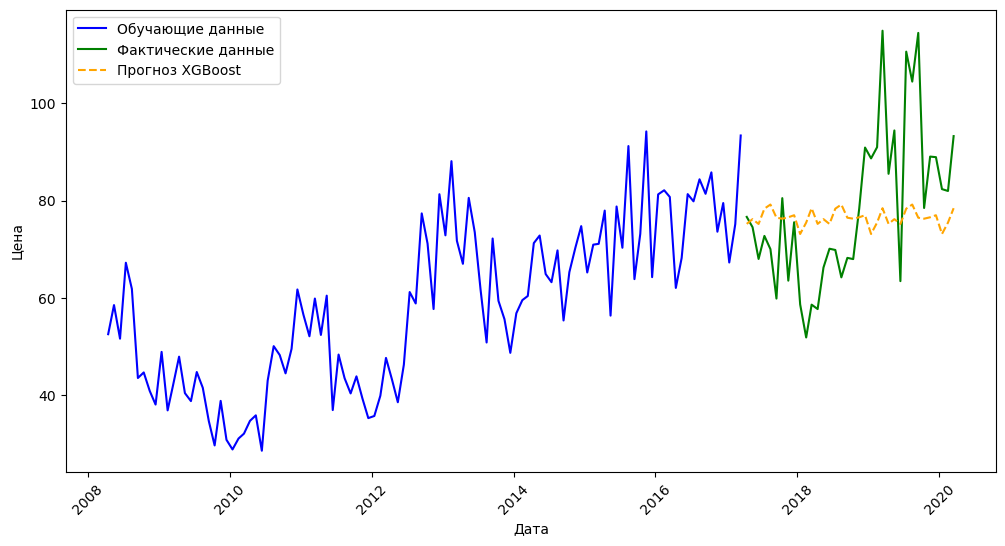

In [44]:

# Создаём дополнительные признаки (месяц, год, день и т.д.)
df_time_series['month'] = df_time_series.index.month
df_time_series['year'] = df_time_series.index.year

# Разделяем данные на обучающую и тестовую выборку
train = df_time_series.iloc[:-36]  # Все данные до последних трех лет — для обучения
test = df_time_series.iloc[-36:]   # Последние 3 года — для тестирования

# Определяем признаки и целевую переменную
X_train = train[['month', 'year']]
y_train = train['price']
X_test = test[['month', 'year']]
y_test = test['price']

# Параметры для случайного поиска
param_dist = {
    'max_depth': [3, 5, 7, 9, 11],  # Глубина дерева
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Скорость обучения
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Доля выборки для каждого дерева
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Доля признаков для каждого дерева
    'gamma': [0, 0.1, 0.2, 0.3],  # Параметр структурной регуляризации
}

# Создаём модель XGBoost
model = XGBRegressor(objective='reg:squarederror')

# Настраиваем случайный поиск с 5-кратной кросс-валидацией
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, verbose=1, n_jobs=-1)

# Обучаем модель с помощью случайного поиска
random_search.fit(X_train, y_train)

# Лучшие параметры из случайного поиска
print(f'Лучшие параметры: {random_search.best_params_}')

# Получаем модель с лучшими гиперпараметрами
best_model = random_search.best_estimator_

# Прогноз
predictions = best_model.predict(X_test)

# Оцениваем качество модели
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# График
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train, label='Обучающие данные', color='blue')
plt.plot(test.index, y_test, label='Фактические данные', color='green')
plt.plot(test.index, predictions, label='Прогноз XGBoost', color='orange', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.show()


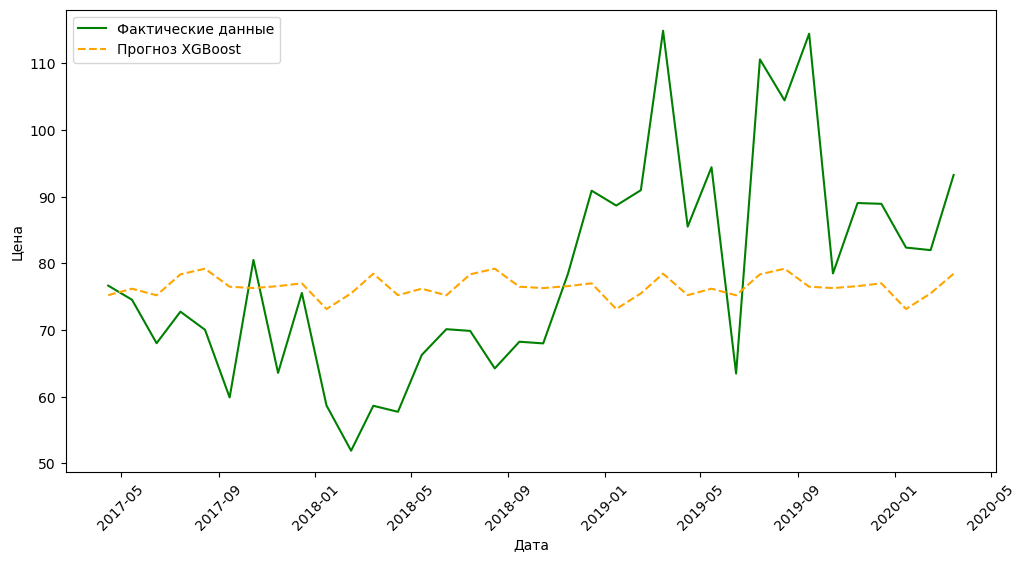

In [45]:
# Визуализация прогноза за последние 3 года
plt.figure(figsize=(12, 6))

plt.plot(test.index, y_test, label='Фактические данные', color='green')
plt.plot(test.index, predictions, label='Прогноз XGBoost', color='orange', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [47]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=50)
model.fit(X_train, y_train)

# Генерация будущих дат
future_dates = pd.date_range(start=df_time_series.index[-1], periods=37, freq='M')[1:]
future_features = pd.DataFrame({
    'month': future_dates.month,
    'year': future_dates.year,
})

# Прогноз
future_predictions = model.predict(future_features)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


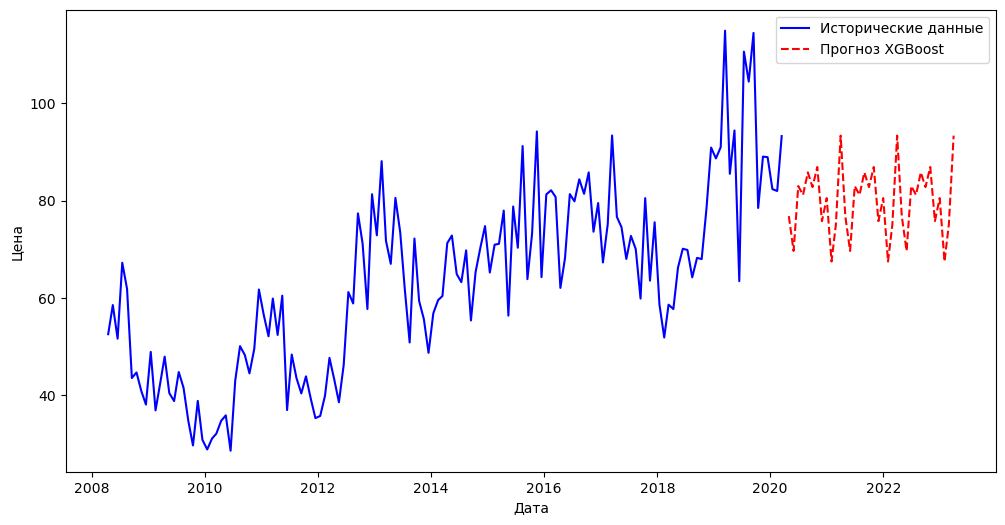

In [50]:
predictions = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(df_time_series.index, df_time_series['price'], label='Исторические данные', color='blue')
plt.plot(future_dates, future_predictions, label='Прогноз XGBoost', color='red', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0922 - val_loss: 0.0427
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0430 - val_loss: 0.0334
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0248 - val_loss: 0.0723
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0268 - val_loss: 0.0375
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - val_loss: 0.0247
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - val_loss: 0.0237
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - val_loss: 0.0357
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209 - val_loss: 0.0269
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - val_loss: 0.0251
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - val_loss: 0.0265
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - val_loss: 0.0282
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0185 - val_loss: 0.0226
Epoch 13

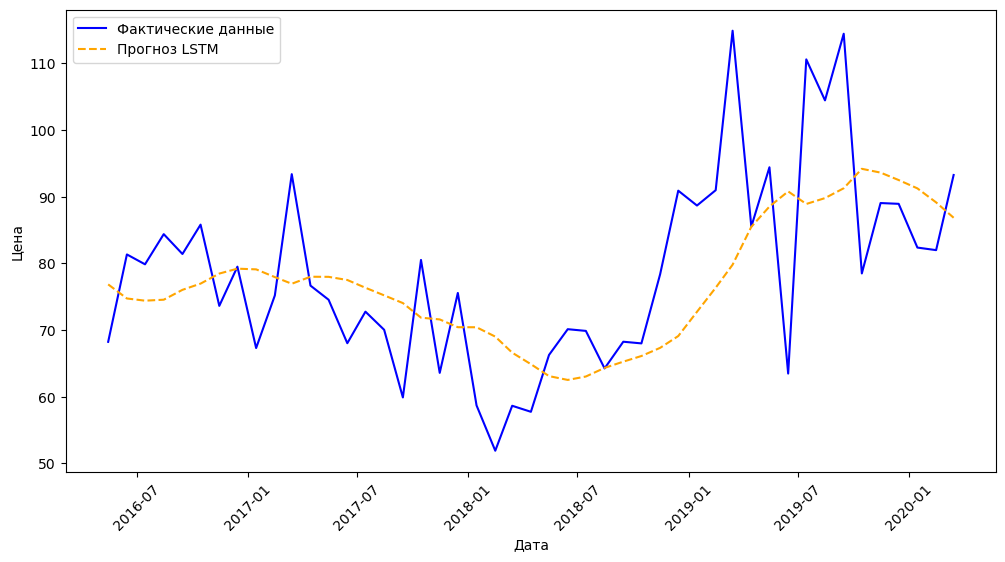

In [49]:
# Нормализация данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_time_series['price'].values.reshape(-1, 1))

# Подготовка данных для LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Определяем временной шаг
time_step = 12
X, y = create_dataset(scaled_data, time_step)

# Преобразуем форму для входа в LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Разделяем данные на обучающую и тестовую выборку
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создаём модель LSTM
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Помогает предотвратить переобучение
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Прогноз на тестовой выборке
predictions = model.predict(X_test)

# Обратное преобразование к реальному масштабу
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# График
plt.figure(figsize=(12, 6))
plt.plot(df_time_series.index[-len(y_test):], y_test, label='Фактические данные', color='blue')
plt.plot(df_time_series.index[-len(predictions):], predictions, label='Прогноз LSTM', color='orange', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.show()


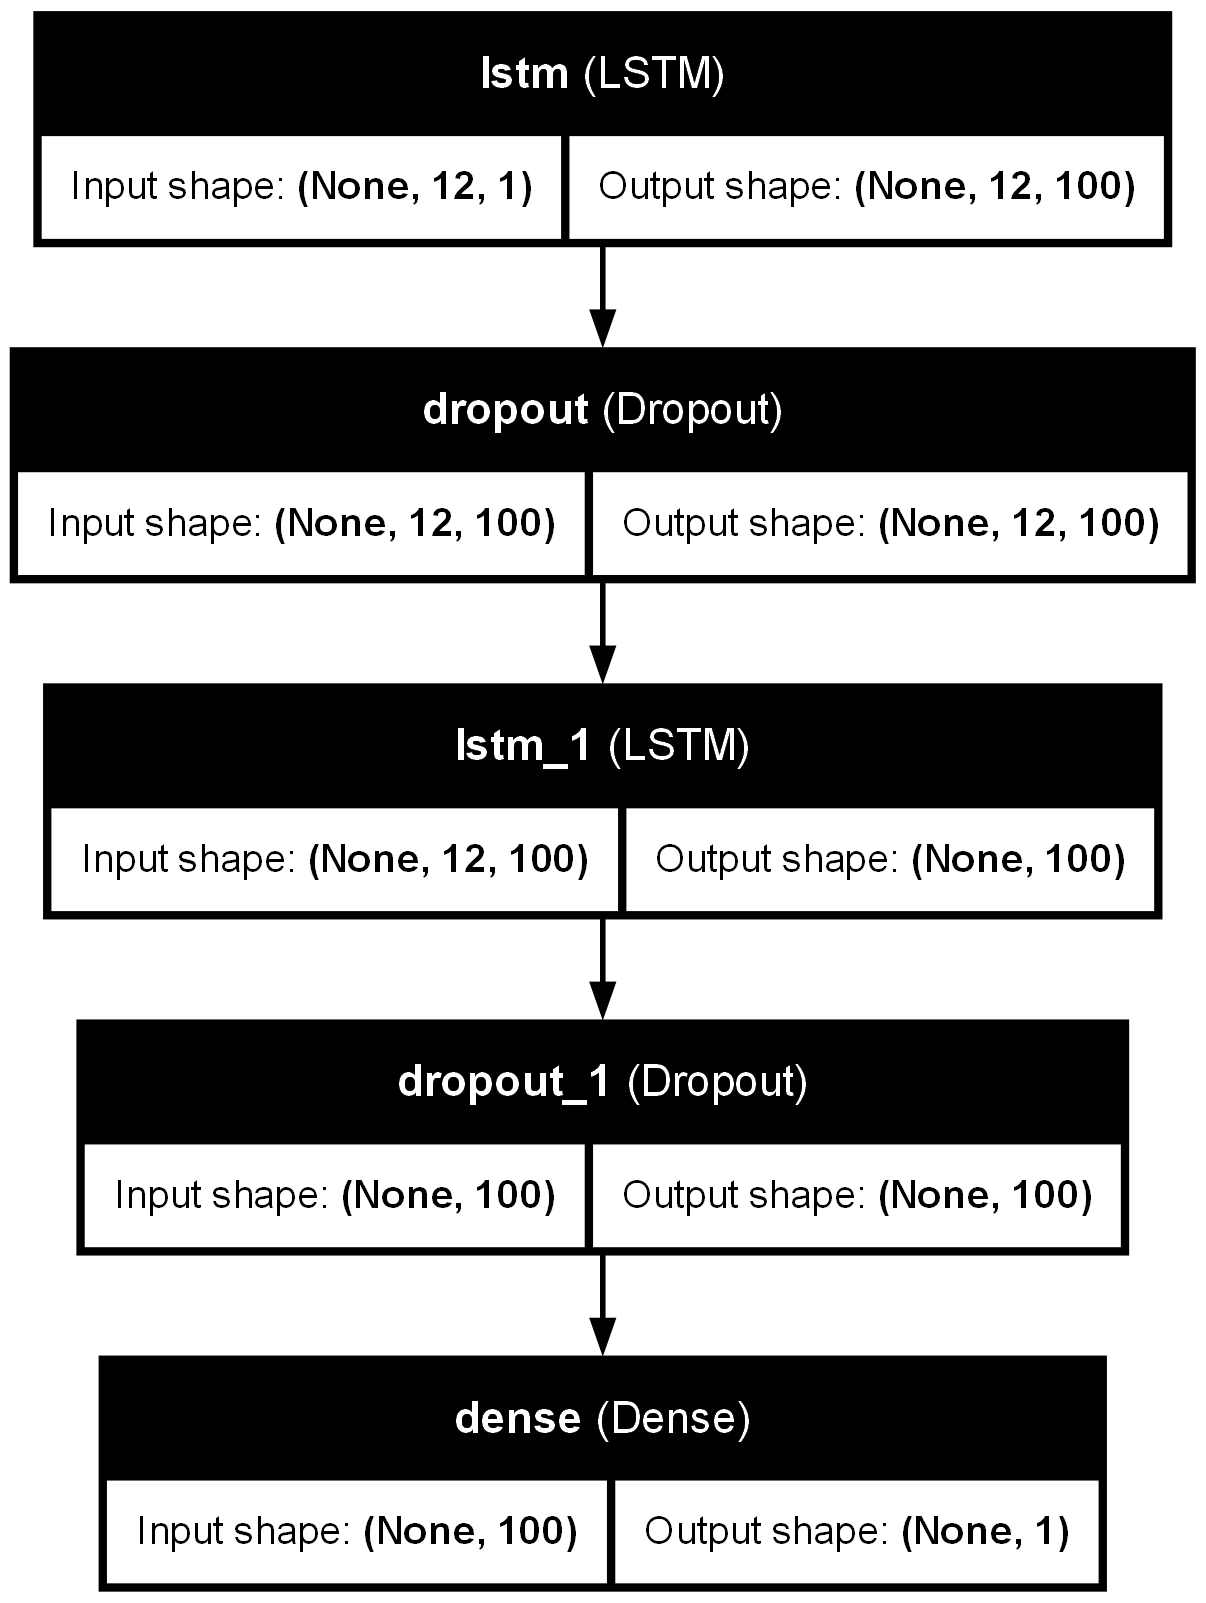

In [51]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='lstm_model.png')

In [52]:
# Генерация будущих значений
future_steps = 36
future_input = scaled_data[-time_step:]  # последние 12 точек
future_input = future_input.reshape(1, time_step, 1)

future_predictions_scaled = []
for _ in range(future_steps):
    next_pred = model.predict(future_input)[0]
    future_predictions_scaled.append(next_pred)
    future_input = np.append(future_input[:, 1:, :], [[next_pred]], axis=1)

# Обратное преобразование предсказаний
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled))

# Генерация будущих дат
last_date = df_time_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

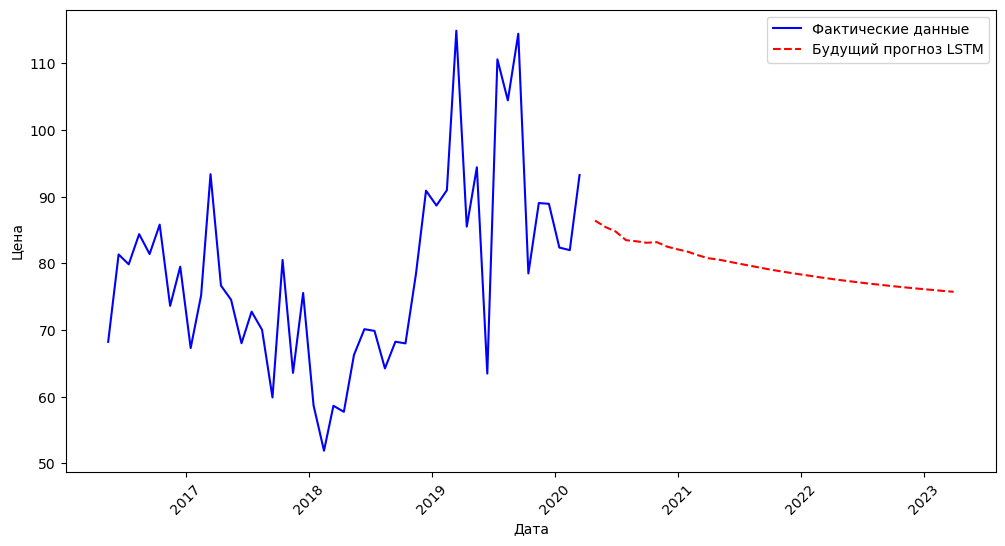

In [53]:
plt.figure(figsize=(12, 6))
# Исторические фактические значения
plt.plot(df_time_series.index[-len(y_test):], y_test, label='Фактические данные', color='blue')
# Прогноз на будущее
plt.plot(future_dates, future_predictions, label='Будущий прогноз LSTM', color='red', linestyle='dashed')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.show()
